In [28]:
!pip install transformers
!pip install sentencepiece
!pip install wordpiece


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 14.0 MB/s 
     |████████████████████████████████| 596 kB 74.0 MB/s 
     |████████████████████████████████| 86 kB 7.3 MB/s 
     |████████████████████████████████| 6.6 MB 53.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 13.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for wordpiece: filename=wordpiece-0.0.0-py3-none-any.whl size=1997 sha256=db968744dcda647bcb849d608f5dc3e15d5e359d172a2e230b

In [ ]:


%%writefile roBERTa.py

from typing import List, Tuple, Union
from io import StringIO
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import torch
from torch import Tensor
import torch.nn.functional as F
import numpy as np
import torch
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers import RobertaTokenizer, RobertaForMaskedLM
import heapq
from heapq import heappop, heappush

class MaskedStego:
  


    def __init__(self,name = 'roberta-base'): #cased bert means that uppercase, accent markers are accepted 
        self._tokenizer: PreTrainedTokenizer = RobertaTokenizer.from_pretrained(name)
        self._model = RobertaForMaskedLM.from_pretrained(name)
        self._STOPWORDS: List[str] = stopwords.words('english')
        

    def __call__(self, cover_text, message, mask_interval = 3, score_threshold = 0.01): 
        assert set(message) <= set('01') #make sure that the binary message is a set of 0s and 1s
        message_io = StringIO(message) 
        #pre-processing cover text inserted 
        #encode process goes through 4 steps normalization of cover text, pre-tokenizing, model, decoding. (similar to tokenizer.encode)
        encoded_ids= self._tokenizer([cover_text],return_tensors='pt').input_ids[0] #returns a tensor for each word of the cover text, tensor is numerical representation for each word within the cover text
        
        masked_ids= self._mask(encoded_ids.clone(),mask_interval) #masked ids are the position embeddings for each word
        sorted_score, indices= self._predict(masked_ids)
        

        processed= { 'input_ids': encoded_ids, 'masked_ids': masked_ids, 'sorted_output': (sorted_score, indices) }
        
        input_ids = processed['input_ids'] 
        masked_ids = processed['masked_ids'] #1 for words and 0 for paddings
        sorted_score, indices = processed['sorted_output']
        for i_token, token in enumerate(masked_ids):
            if token != self._tokenizer.mask_token_id:
                continue
            ids = indices[i_token]
            scores = sorted_score[i_token]
            #picks candidates according to their scores that must be of probability more than the set threshold 0.01 for encoding and 0.005 for decoding
            candidates = self._pick_candidates_threshold(ids, scores, score_threshold)
            print(candidates)
            print(self._tokenizer.convert_ids_to_tokens(candidates)) #all suitable words to be placed in the [mask] position
            
            replace_token_id = self._block_encode_single(candidates, message_io).item() #perfect binary tree btakhod el candidates w btkhtar el suitable words for the bit sequence of our secret message
            
            print('replace', replace_token_id, self._tokenizer.convert_ids_to_tokens([replace_token_id]))
            input_ids[i_token] = replace_token_id #hena byghyar el [Mask] tokens into the replace_token_id tensor to be converted to tokens in the decode part coming (tokenizer.decode)
            
        encoded_message: str = message_io.getvalue()[:message_io.tell()]
        
        message_io.close()
        stego_text = self._tokenizer.decode(input_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        #self._roBERTa(cover_text,message);
        
        return { 'stego_text by roBERTa': stego_text, 'encoded_message': encoded_message }

   

    def _mask(self, input_ids: Union[Tensor, List[List[int]]], mask_interval: int) -> Tensor:
        length = len(input_ids)
        tokens: List[str] = self._tokenizer.convert_ids_to_tokens(input_ids)
        
        offset = mask_interval // 2 + 1 #the offset specify the number of [mask] tokens according to the specified mask_interval 
        
        mask_count = offset
        for i, token in enumerate(tokens):
            # Skip initial subword
            if i + 1 < length and tokens[i + 1].startswith('##'): continue
            if not self._substitutable_single(token): continue #skipping stopwords, subwords, and words that are not within the (a-z) letters.
            if mask_count % mask_interval == 0: 
                input_ids[i] = self._tokenizer.mask_token_id #replace the value of this index (normal word) with the [mask] token whose input_id equals to 103   
            mask_count += 1  
       
        return input_ids

    
    #forward neural network layer
    def _predict(self, input_ids: Union[Tensor, List[List[int]]]): #this is the MLM (masked language model)
        self._model.eval()
        with torch.no_grad():
            output = self._model(input_ids.unsqueeze(0))['logits'][0] #The predicted token_id is extracted from this logit (embedding vector resulting from last encoder layer in bert) using a softmax transformation.
            #softmaxed score is applying softmax on the scores to focus on the ones with high scores
            softmaxed_score = F.softmax(output, dim=1)  # [word_len, vocab_len]
            return softmaxed_score.sort(dim=1, descending=True)

    
   
    def _pick_candidates_threshold(self, ids: Tensor, scores: Tensor, threshold: float) -> List[int]:
        filtered_ids: List[int] = ids[scores >= threshold]
        def filter_fun(idx: Tensor) -> bool:
            
            return self._substitutable_single(self._tokenizer.convert_ids_to_tokens(idx.item()))
        return list(filter(filter_fun, filtered_ids))

    def _substitutable_single(self, token: str) -> bool:
        if token.startswith('##'): return False
        if token.lower() in self._STOPWORDS: return False
        if not token.isalpha(): return False
        return True

    @staticmethod
    def _block_encode_single(ids: List[int], message: StringIO) -> int:  #Indexing
        assert len(ids) > 0
        if len(ids) == 1:
            return ids[0]
        capacity = len(ids).bit_length() - 1
        #print(capacity)
        bits_str = message.read(capacity)
        print("part of bit sequence",bits_str)
        if len(bits_str) < capacity:
            padding: str = '0' * (capacity - len(bits_str))
            bits_str = bits_str + padding
            message.write(padding)
        index = int(bits_str, 2) #from binary to number
        print("index",index)
        return ids[index]


 
 
def isLeaf(root):
    return root.left is None and root.right is None
 
 
# A Tree node
class Node:
    def __init__(self, ch, freq, left=None, right=None):
        self.ch = ch
        self.freq = freq
        self.left = left
        self.right = right
 
    
    def __lt__(self, other):
        return self.freq < other.freq
 
 
# Traverse the Huffman Tree and store Huffman Codes in a dictionary
def encode(root, s, huffman_code):
 
    if root is None:
        return
 
    # found a leaf node
    if isLeaf(root):
        huffman_code[root.ch] = s if len(s) > 0 else '1'
 
    encode(root.left, s + '0', huffman_code)
    encode(root.right, s + '1', huffman_code)
 
 

 
 
# Builds Huffman Tree and decodes the given input text
def buildHuffmanTree(text):
 
    # base case: empty string
    if len(text) == 0:
        return
 
    # count the frequency of appearance of each character
    # and store it in a dictionary
    freq = {i: text.count(i) for i in set(text)}
 
    # Create a priority queue to store live nodes of the Huffman tree.
    pq = [Node(k, v) for k, v in freq.items()]
    heapq.heapify(pq)
 
    # do till there is more than one node in the queue
    while len(pq) != 1:
 
        # Remove the two nodes of the highest priority
        # (the lowest frequency) from the queue
 
        left = heappop(pq)
        right = heappop(pq)
 
        # create a new internal node with these two nodes as children and
        # with a frequency equal to the sum of the two nodes' frequencies.
        # Add the new node to the priority queue.
 
        total = left.freq + right.freq
        heappush(pq, Node(None, total, left, right))
 
    # `root` stores pointer to the root of Huffman Tree
    root = pq[0]
 
    # traverse the Huffman tree and store the Huffman codes in a dictionary
    huffmanCode = {}
    encode(root, '', huffmanCode)
 
 
    # print the encoded string
    s = ''
    for c in text:
        s += huffmanCode.get(c)
 
    return s
    
 



#Final Testing
if __name__ == '__main__':

  val = input("Enter your cover text: ")
  message= input("Enter secret message ")
  tobits=buildHuffmanTree(message)
  masked_stego = MaskedStego()
  print(masked_stego(val, tobits, 3, 0.01))
  
 
  
   

  




Overwriting roBERTa.py


In [ ]:
!python3 roBERTa.py 



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Enter your cover text: The consensus among scientists is that we are in an era of global heating and extreme weather events, primarily due to the devastating effects of human action on the environment.
Enter secret message Help Please
[tensor(566), tensor(9783), tensor(9)]
['Ġamong', 'Ġamongst', 'Ġof']
part of bit sequence 0
index 0
replace 566 ['Ġamong']
[tensor(14)]
['Ġthat']
replace 14 ['Ġthat']
[tensor(4201), tensor(11)]
['Ġentering', 'Ġin']
part of bit sequence 0
index 0
replace 4201 ['Ġentering']
[tensor(9)]
['Ġof']
replace 9 ['Ġof']
[tensor(8)]
['Ġand']
replace 8 ['Ġand']
[tensor(1061), tensor(31823), tensor(1274), tensor(8117)]
['Ġevents', 'Ġextremes', 'Ġconditions', 'Ġpatterns']
part of bit sequence 01
index 1
replace 31823 ['Ġextremes']
[tensor(7)]
['Ġto']
replace 7 ['Ġto']
[tensor(3038), tensor(913), tensor(7342), tensor(1683), tensor(4914)]
['Ġeffects', 'Ġi

In [29]:
%%writefile Bert.py

from typing import List, Union
from io import StringIO
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import torch
from torch import Tensor
import torch.nn.functional as F
import torch
from transformers import BertTokenizer, BertForMaskedLM
from transformers.tokenization_utils import PreTrainedTokenizer
import heapq
from heapq import heappop, heappush
 
   
       
class MaskedStegoByBert: 
        
    def __init__(self,name='bert-base-cased'): #cased bert means that uppercase, accent markers are accepted 
        self._tokenizer: PreTrainedTokenizer  = BertTokenizer.from_pretrained(name)
        self._model = BertForMaskedLM.from_pretrained(name)
        self._STOPWORDS: List[str] = stopwords.words('english')

    def __call__(self, cover_text, message, mask_interval = 3, score_threshold = 0.01): 
        assert set(message) <= set('01') #make sure that the binary message is a set of 0s and 1s
        message_io = StringIO(message) 
        #pre-processing cover text inserted 
        #encode process goes through 4 steps normalization of cover text, pre-tokenizing, model, decoding. (similar to tokenizer.encode)
        encoded_ids= self._tokenizer([cover_text],return_tensors='pt').input_ids[0] #returns a tensor for each word of the cover text, tensor is numerical representation for each word within the cover text
        
        masked_ids= self._mask(encoded_ids.clone(),mask_interval) #masked ids are the position embeddings for each word
        sorted_score, indices= self._predict(masked_ids)
        

        processed= { 'input_ids': encoded_ids, 'masked_ids': masked_ids, 'sorted_output': (sorted_score, indices) }
        
        input_ids = processed['input_ids'] #single sequence: [CLS] + sentence ids + [SEP]
        masked_ids = processed['masked_ids'] #1 for words and 0 for paddings
        sorted_score, indices = processed['sorted_output']
        for i_token, token in enumerate(masked_ids):
            if token != self._tokenizer.mask_token_id:
                continue
            ids = indices[i_token]
            scores = sorted_score[i_token]
            #picks candidates according to their scores that must be of probability more than the set threshold 0.01 for encoding and 0.005 for decoding
            candidates = self._pick_candidates_threshold(ids, scores, score_threshold)
            print(candidates)
            print(self._tokenizer.convert_ids_to_tokens(candidates)) #all suitable words to be placed in the [mask] position
            
            replace_token_id = self.Indexing(candidates, message_io).item() #perfect binary tree btakhod el candidates w btkhtar el suitable words for the bit sequence of our secret message
            
            print('replace', replace_token_id, self._tokenizer.convert_ids_to_tokens([replace_token_id]))
            input_ids[i_token] = replace_token_id #hena byghyar el [Mask] tokens into the replace_token_id tensor to be converted to tokens in the decode part coming (tokenizer.decode)
            
        encoded_message: str = message_io.getvalue()[:message_io.tell()]
        
        message_io.close()
        stego_text = self._tokenizer.decode(input_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        #self._roBERTa(cover_text,message);
        
        return { 'stego_text by BERT': stego_text, 'encoded_message': encoded_message }

    def decode(self, stego_text, mask_interval = 3, score_threshold = 0.005):
        decoded_message: List[str] = []
        #pre processing stego text.
        encoded_ids= self._tokenizer([stego_text],return_tensors='pt').input_ids[0]
        masked_ids= self._mask(encoded_ids.clone(),mask_interval)
        
        sorted_score, indices= self._predict(masked_ids) 
       
        processed= { 'input_ids': encoded_ids, 'masked_ids': masked_ids, 'sorted_output': (sorted_score, indices) }
        input_ids = processed['input_ids']
        masked_ids = processed['masked_ids']
        sorted_score, indices = processed['sorted_output']
        for i_token, token in enumerate(masked_ids):
            if token != self._tokenizer.mask_token_id: 
                continue
            ids = indices[i_token]
            scores = sorted_score[i_token]
            candidates = self._pick_candidates_threshold(ids, scores, score_threshold)
            if len(candidates) < 2: #if candidates equals 1 or less do nothing as there are more than 1 [mask] to be predicted so will be insufficient candidates so it has to be more than 1
                continue
            chosen_id: int = input_ids[i_token].item()
            decoded_message.append(self._block_decode_single(candidates, chosen_id))
        return {'decoded_message': ''.join(decoded_message)}

   

    def _mask(self, input_ids: Union[Tensor, List[List[int]]], mask_interval: int) -> Tensor:
        length = len(input_ids)
        tokens: List[str] = self._tokenizer.convert_ids_to_tokens(input_ids)
        
        offset = mask_interval // 2 + 1 #the offset specify the number of [mask] tokens according to the specified mask_interval 
        
        mask_count = offset
        for i, token in enumerate(tokens):
            # Skip initial subword
            if i + 1 < length and tokens[i + 1].startswith('##'): continue
            if not self._substitutable_single(token): continue #skipping stopwords, subwords, and words that are not within the (a-z) letters.
            if mask_count % mask_interval == 0: 
                input_ids[i] = self._tokenizer.mask_token_id #replace the value of this index (normal word) with the [mask] token whose input_id equals to 103   
            mask_count += 1  
       
        return input_ids

    
    #forward neural network layer
    def _predict(self, input_ids: Union[Tensor, List[List[int]]]): #this is the MLM (masked language model)
        self._model.eval()
        with torch.no_grad():
            output = self._model(input_ids.unsqueeze(0))['logits'][0] #The predicted token_id is extracted from this logit (embedding vector resulting from last encoder layer in bert) using a softmax transformation.
            #softmaxed score is applying softmax on the scores to focus on the ones with high scores
            softmaxed_score = F.softmax(output, dim=1)  # [word_len, vocab_len]
            return softmaxed_score.sort(dim=1, descending=True)

    
   
    def _pick_candidates_threshold(self, ids: Tensor, scores: Tensor, threshold: float) -> List[int]:
        filtered_ids: List[int] = ids[scores >= threshold]
        def filter_fun(idx: Tensor) -> bool:
            return self._substitutable_single(self._tokenizer.convert_ids_to_tokens(idx.item()))
        return list(filter(filter_fun, filtered_ids))

    def _substitutable_single(self, token: str) -> bool:
        if token.startswith('##'): return False
        if token.lower() in self._STOPWORDS: return False
        if not token.isalpha(): return False
        return True

    @staticmethod
    def Indexing(ids: List[int], message: StringIO) -> int: 
        assert len(ids) > 0
        if len(ids) == 1:
            return ids[0]
        capacity = len(ids).bit_length() - 1
        #print(capacity)
        bits_str = message.read(capacity)
        print("Secret message bit sequence chunk: ",bits_str)
        if len(bits_str) < capacity:
            padding: str = '0' * (capacity - len(bits_str))
            bits_str = bits_str + padding
            message.write(padding)
        index = int(bits_str, 2) #from binary to number
        #print("index",index)
        return ids[index]

    @staticmethod
    def _block_decode_single(ids: List[int], chosen_id: int) -> str:
        if len(ids) < 2:
            return ''
        capacity = len(ids).bit_length() - 1
        index = ids.index(chosen_id)
        return format(index, '0' + str(capacity) +'b')


def isLeaf(root):
    return root.left is None and root.right is None
 
 
# A Tree node
class Node:
    def __init__(self, ch, freq, left=None, right=None):
        self.ch = ch
        self.freq = freq
        self.left = left
        self.right = right
 
    
    def __lt__(self, other):
        return self.freq < other.freq
 
 
# Traverse the Huffman Tree and store Huffman Codes in a dictionary
def encode(root, s, huffman_code):
 
    if root is None:
        return
 
    # found a leaf node
    if isLeaf(root):
        huffman_code[root.ch] = s if len(s) > 0 else '1'
 
    encode(root.left, s + '0', huffman_code)
    encode(root.right, s + '1', huffman_code)
 
 

 
 
# Builds Huffman Tree and decodes the given input text
def buildHuffmanTree(text):
 
    # base case: empty string
    if len(text) == 0:
        return
 
    # count the frequency of appearance of each character
    # and store it in a dictionary
    freq = {i: text.count(i) for i in set(text)}
 
    # Create a priority queue to store live nodes of the Huffman tree.
    pq = [Node(k, v) for k, v in freq.items()]
    heapq.heapify(pq)
 
    # do till there is more than one node in the queue
    while len(pq) != 1:
 
        # Remove the two nodes of the highest priority
        # (the lowest frequency) from the queue
 
        left = heappop(pq)
        right = heappop(pq)
 
        # create a new internal node with these two nodes as children and
        # with a frequency equal to the sum of the two nodes' frequencies.
        # Add the new node to the priority queue.
 
        total = left.freq + right.freq
        heappush(pq, Node(None, total, left, right))
 
    # `root` stores pointer to the root of Huffman Tree
    root = pq[0]
 
    # traverse the Huffman tree and store the Huffman codes in a dictionary
    huffmanCode = {}
    encode(root, '', huffmanCode)
 
 
    # print the encoded string
    s = ''
    for c in text:
        s += huffmanCode.get(c)
 
    return s;


#Final Testing
if __name__ == '__main__':

  val = input("Enter your cover text/stego text: ")
  message= input("Enter secret message ")
  tobits=buildHuffmanTree(message)
  print('Bit sequence of secret message: ',tobits)
  masked_stego = MaskedStegoByBert()
  print(masked_stego(val, tobits, 3, 0.01))



Overwriting Bert.py


In [30]:
!python3 Bert.py



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Enter your cover text/stego text: A new study published in the journal Frontier in Behavioral Neuroscience shows that older individuals tend to release more oxytocin in response to social situations that arouse empathy. A larger oxytocin response was also associated with greater levels of helping behaviors and increased satisfaction with life.
Enter secret message meet me at downtown at 9
Bit sequence of secret message:  10101001001110110101000100111101000011001011110111111001011110101001111010001
Downloading: 100% 208k/208k [00:00<00:00, 833kB/s] 
Downloading: 100% 29.0/29.0 [00:00<00:00, 38.7kB/s]
Downloading: 100% 570/570 [00:00<00:00, 759kB/s]
Downloading: 100% 416M/416M [00:06<00:00, 65.0MB/s]
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This 

In [38]:
%%writefile gpt2.py
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import imp
import random
from typing import List, Union
#encode = imp.load_source('encoding', 'C:\\Users\\admin\\Desktop\\GP papers\\sample\\mds20_stega-master\\src\\utils\\encoding.py')
from io import StringIO
import heapq
from heapq import heappop, heappush
import sys
TOKEN_COUNT = 16
TOKEN_COUNT_LOG = int(np.log2(TOKEN_COUNT))


def init_model(name='gpt2'):
    model = GPT2LMHeadModel.from_pretrained(name, pad_token_id=50256)
    tokenizer = GPT2Tokenizer.from_pretrained(name, pad_token_id=50256)
    model.eval()
    return model, tokenizer 



def generate(model, init_tokens, seq, tokenizer,message):
    generate_count = len(seq) % TOKEN_COUNT_LOG
    if generate_count != 0:
        generate_count = TOKEN_COUNT_LOG - generate_count

    seq = seq + [0] * generate_count
    
    max_idx = len(seq) // TOKEN_COUNT_LOG

    tokens = tokenizer.encode(init_tokens, return_tensors='pt')
    init_len = tokens.shape[1]
    

    for idx in range(max_idx):
        out = model.generate(
            tokens,
            max_length=1 + idx + init_len,
            num_return_sequences=TOKEN_COUNT,
            num_beams=TOKEN_COUNT,
            early_stopping=True
        )

      
        
        #idx refers to the probability in each index of the stegotext need then it matches the indx with the candidate if yes then this probability is the right one
        

        candidates = out[:, -1]
       
        idx= Indexing(candidates,message);
        print('index of candidate chosen in list of candidates: ', idx, 'candidate: ', tokenizer.decode(candidates[idx].item()))
        candidate= candidates[idx].item()
        tokens = torch.cat(
            (tokens, torch.tensor([[candidate]])), axis=-1 #concatinates all the given tensors
        )

    text = tokenizer.decode(tokens[0],skip_special_tokens=True) #we decode the generated output so that it can be presented in human-readable format instead of some cryptic token indices.


    return text




def Indexing(ids: List[int], message: StringIO) -> int: 
        assert len(ids) > 0
        if len(ids) == 1:
            return ids[0]
        capacity = len(ids).bit_length() - 1
        #print(capacity)
        bits_str = message.read(capacity)
        #print("secret message bit sequence chunk: ",bits_str)
        if len(bits_str) < capacity:
            padding: str = '0' * (capacity - len(bits_str))
            bits_str = bits_str + padding
            message.write(padding)
        index = int(bits_str, 2) #from binary to number
        #print("index",index)
        return index
    
def _test(seq_len,message):
    message_io = StringIO(message) 

    seq = list(
        np.random.binomial(1, 0.5, seq_len)
    )

    model, tokenizer = init_model()
    
  
# Open the file in read mode
    with open("academic.txt", "r") as file:
      data = file.read();
      words = data.split();
      n=0
      
    # Generating a random number for word position
    
      word_pos = random.randint(0, len(words)-1)
      print('Randomly selected word: ',words[word_pos])
    
      text1 = generate(model, words[word_pos], seq, tokenizer,message_io)
      text = text1.replace("\n", " ")
      print('GPT2 Output: ',f'{text}',end='. ')
        

def isLeaf(root):
    return root.left is None and root.right is None
         
# A Tree node
class Node:
    def __init__(self, ch, freq, left=None, right=None):
        self.ch = ch
        self.freq = freq
        self.left = left
        self.right = right
 
    
    def __lt__(self, other):
        return self.freq < other.freq
 
 
# Traverse the Huffman Tree and store Huffman Codes in a dictionary
def encode(root, s, huffman_code):
 
    if root is None:
        return
 
    # found a leaf node
    if isLeaf(root):
        huffman_code[root.ch] = s if len(s) > 0 else '1'
 
    encode(root.left, s + '0', huffman_code)
    encode(root.right, s + '1', huffman_code)
    
def buildHuffmanTree(text):
 
    # base case: empty string
    if len(text) == 0:
        return
 
    # count the frequency of appearance of each character
    # and store it in a dictionary
    freq = {i: text.count(i) for i in set(text)}
 
    # Create a priority queue to store live nodes of the Huffman tree.
    pq = [Node(k, v) for k, v in freq.items()]
    heapq.heapify(pq)
 
    # do till there is more than one node in the queue
    while len(pq) != 1:
 
        # Remove the two nodes of the highest priority
        # (the lowest frequency) from the queue
 
        left = heappop(pq)
        right = heappop(pq)
 
        # create a new internal node with these two nodes as children and
        # with a frequency equal to the sum of the two nodes' frequencies.
        # Add the new node to the priority queue.
 
        total = left.freq + right.freq
        heappush(pq, Node(None, total, left, right))
 
    # `root` stores pointer to the root of Huffman Tree
    root = pq[0]
 
    # traverse the Huffman tree and store the Huffman codes in a dictionary
    huffmanCode = {}
    encode(root, '', huffmanCode)
 
 
    # print the encoded string
    s = ''
    for c in text:
        s += huffmanCode.get(c)
 
    return s;

if __name__ == '__main__':
    model, tokenizer = init_model()
    message= input("Enter secret message ")
    tobits= buildHuffmanTree(message)
    print('Secret message encoded into bit sequence: ',tobits)
    

   
    _test(100,tobits)

Overwriting gpt2.py


In [39]:
!python3 gpt2.py


Enter secret message help please
Secret message encoded into bit sequence:  000101111100011101111001101010
Randomly selected word:  students’
index of candidate chosen in list of candidates:  1 candidate:   and
index of candidate chosen in list of candidates:  7 candidate:   they
index of candidate chosen in list of candidates:  12 candidate:   did
index of candidate chosen in list of candidates:  7 candidate:   well
index of candidate chosen in list of candidates:  7 candidate:   for
index of candidate chosen in list of candidates:  9 candidate:   those
index of candidate chosen in list of candidates:  10 candidate:  .
index of candidate chosen in list of candidates:  8 candidate:   It
index of candidate chosen in list of candidates:  0 candidate:  's
index of candidate chosen in list of candidates:  0 candidate:   not
index of candidate chosen in list of candidates:  0 candidate:   that
index of candidate chosen in list of candidates:  0 candidate:   they
index of candidate chosen in

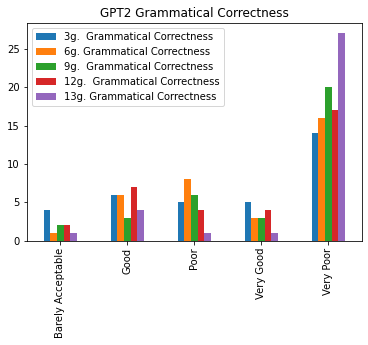

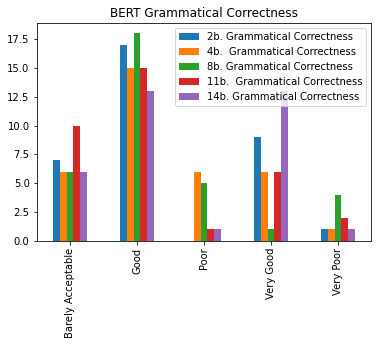

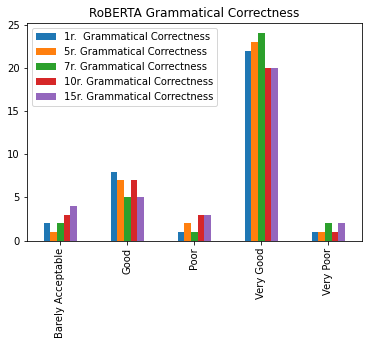

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
GPT2GrammaticalCorrectness = pd.read_excel(r'Human evaluation.xlsx' ,usecols='K,R,X,AD,AF')
BERTGrammaticalCorrectness = pd.read_excel(r'Human evaluation.xlsx',usecols='H,N,V,AB,AH')
RoBERTAGrammaticalCorrectness = pd.read_excel(r'Human evaluation.xlsx',usecols='E,P,T,Z,AJ')

#Each Model's evaluation in Grammatical Correctness
print()
GPT2GrammaticalCorrectness.apply(pd.Series.value_counts).plot(kind='bar',title="GPT2 Grammatical Correctness")
BERTGrammaticalCorrectness.apply(pd.Series.value_counts).plot(kind='bar',title="BERT Grammatical Correctness")
RoBERTAGrammaticalCorrectness.apply(pd.Series.value_counts).plot(kind='bar',title="RoBERTA Grammatical Correctness")

print()
##### Please check the Human evaluation.py file for comparison between three models according to human's ratings ####

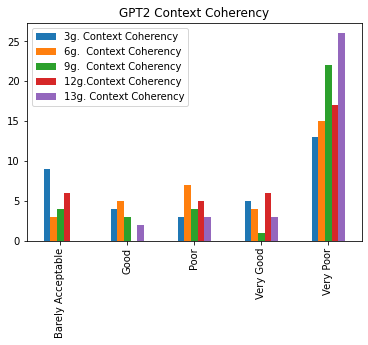

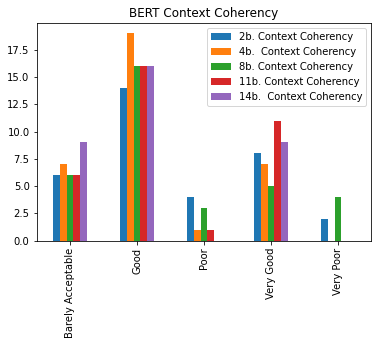

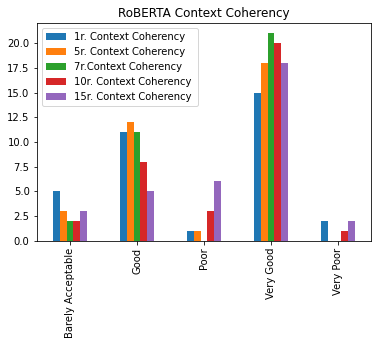

In [22]:
#Each Model's evaluation in Context Coherency
GPT2ContextCoherency = pd.read_excel(r'Human evaluation.xlsx' ,usecols='J,Q,W,AC,AE')
BERTContextCoherency = pd.read_excel(r'Human evaluation.xlsx',usecols='G,M,U,AA,AG')
RoBERTaContextCoherency = pd.read_excel(r'Human evaluation.xlsx',usecols='D,O,S,Y,AI')
GPT2ContextCoherency.apply(pd.Series.value_counts).plot(kind='bar',title="GPT2 Context Coherency")
BERTContextCoherency.apply(pd.Series.value_counts).plot(kind='bar',title="BERT Context Coherency")
RoBERTaContextCoherency.apply(pd.Series.value_counts).plot(kind='bar',title="RoBERTA Context Coherency")

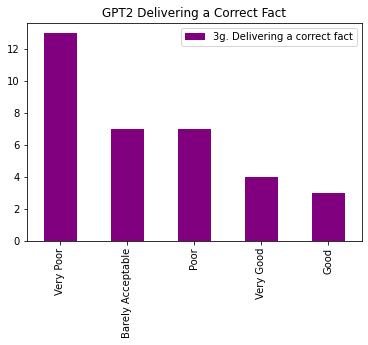

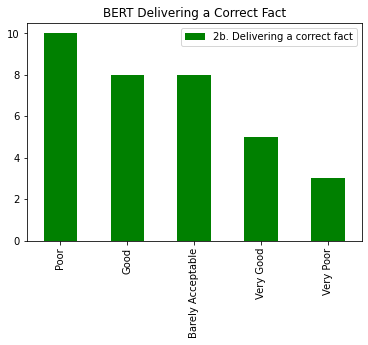

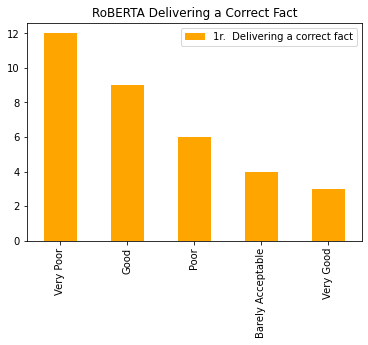

In [24]:
#Each Model's evaluation in Delivering a correct fact for Political Purposes
GPT2DeliverngaCorrectFact = pd.read_excel(r'Human evaluation.xlsx' ,usecols='L')
BERTDeliverngaCorrectFact = pd.read_excel(r'Human evaluation.xlsx',usecols='I')
RoBERTaDeliverngaCorrectFact = pd.read_excel(r'Human evaluation.xlsx',usecols='F')
GPT2DeliverngaCorrectFact.apply(pd.Series.value_counts).plot(kind='bar',title="GPT2 Delivering a Correct Fact", color="purple")
BERTDeliverngaCorrectFact.apply(pd.Series.value_counts).plot(kind='bar',title="BERT Delivering a Correct Fact",color="green")
RoBERTaDeliverngaCorrectFact.apply(pd.Series.value_counts).plot(kind='bar',title="RoBERTA Delivering a Correct Fact",color="orange")